In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import numpy as np
import os

def generate_hic(size=64, noise=0.05):
    mat = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            mat[i, j] = np.exp(-abs(i - j) / 10)
    mat += noise * np.random.randn(size, size)
    mat = (mat + mat.T) / 2 
    return mat

def generate_sequence(T=3, size=64):
    return np.stack([generate_hic(size) * (1 + 0.02 * t) for t in range(T)])

def create_dataset(
    num_samples=500,
    T=3,
    size=64,
    save_dir="data/synthetic_hic"
):
    os.makedirs(save_dir, exist_ok=True)

    X, Y = [], []

    for _ in range(num_samples):
        seq = generate_sequence(T=T, size=size)
        X.append(seq[:-1])   
        Y.append(seq[-1])   

    X = np.array(X) 
    Y = np.array(Y)  

    np.save(os.path.join(save_dir, "X.npy"), X)
    np.save(os.path.join(save_dir, "Y.npy"), Y)

    print("Dataset saved:")
    print("X shape:", X.shape)
    print("Y shape:", Y.shape)

create_dataset(num_samples=500)

Dataset saved:
X shape: (500, 2, 64, 64)
Y shape: (500, 64, 64)


**Training Pipeline**

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class HiCDataset(Dataset):
    def __init__(self, x_path, y_path):
        self.X = np.load(x_path)
        self.Y = np.load(y_path)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

dataset = HiCDataset(
    "data/synthetic_hic/X.npy",
    "data/synthetic_hic/Y.npy"
)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

**Baseline CNN**

In [7]:
import torch
import torch.nn as nn

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

**Train the BASELINE Model (Before Improvement)**

In [8]:
import torch.nn as nn
import torch.optim as optim

model = BaselineCNN().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 0.0020
Epoch 1: Loss = 0.0014
Epoch 2: Loss = 0.0014
Epoch 3: Loss = 0.0014
Epoch 4: Loss = 0.0014
Epoch 5: Loss = 0.0014
Epoch 6: Loss = 0.0014
Epoch 7: Loss = 0.0014
Epoch 8: Loss = 0.0014
Epoch 9: Loss = 0.0014


In [9]:
torch.save(model.state_dict(), "baseline.pth")

**Evaluation metrices before improvements**

In [10]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
from scipy.stats import pearsonr

criterion = nn.MSELoss()


def compute_ssim(pred, target):
    pred = pred.squeeze().cpu().numpy()
    target = target.squeeze().cpu().numpy()
    return ssim(pred, target, data_range=target.max() - target.min())

def compute_pcc(pred, target):
    pred = pred.flatten().cpu().numpy()
    target = target.flatten().cpu().numpy()
    return pearsonr(pred, target)[0]

In [11]:
model.eval()

mse_scores, ssim_scores, pcc_scores = [], [], []

with torch.no_grad():
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        pred = model(x)

        mse_scores.append(criterion(pred, y).item())
        ssim_scores.append(compute_ssim(pred[0], y[0]))
        pcc_scores.append(compute_pcc(pred[0], y[0]))

print("Baseline Results:")
print("MSE:", np.mean(mse_scores))
print("SSIM:", np.mean(ssim_scores))
print("PCC:", np.mean(pcc_scores))

Baseline Results:
MSE: 0.0014011139024256004
SSIM: 0.7868201755173593
PCC: 0.9915367


In [12]:
import json

results = {
    "MSE": float(np.mean(mse_scores)),
    "SSIM": float(np.mean(ssim_scores)),
    "PCC": float(np.mean(pcc_scores))
}

with open("baseline_metrics.json", "w") as f:
    json.dump(results, f, indent=4)

**THE ATTENTION-BASED IMPROVED MODEL (Single-head)**

In [13]:
import torch
import torch.nn as nn

class TemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x, return_weights=False):
        scores = []
        for t in range(x.shape[1]):
            pooled = self.pool(x[:, t]).view(x.size(0), -1)
            score = self.fc(pooled)
            scores.append(score)

        scores = torch.stack(scores, dim=1)  
        weights = torch.softmax(scores, dim=1)

        fused = (x * weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

        if return_weights:
            return fused, weights
        return fused

In [14]:
class AttentionCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )

        self.attention = TemporalAttention(channels=64)

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x, return_weights=False):
        feats = []
        for t in range(x.shape[1]):
            feats.append(self.encoder(x[:, t:t+1]))

        feats = torch.stack(feats, dim=1)

        if return_weights:
            fused, weights = self.attention(feats, return_weights=True)
            out = self.decoder(fused)
            return out, weights

        fused = self.attention(feats)
        return self.decoder(fused)

In [15]:
import torch.optim as optim
attn_model = AttentionCNN().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(attn_model.parameters(), lr=1e-3)

for epoch in range(10):
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        optimizer.zero_grad()
        pred = attn_model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

    print(f"[Attention] Epoch {epoch}: Loss = {loss.item():.4f}")

[Attention] Epoch 0: Loss = 0.0023
[Attention] Epoch 1: Loss = 0.0016
[Attention] Epoch 2: Loss = 0.0015
[Attention] Epoch 3: Loss = 0.0014
[Attention] Epoch 4: Loss = 0.0014
[Attention] Epoch 5: Loss = 0.0014
[Attention] Epoch 6: Loss = 0.0014
[Attention] Epoch 7: Loss = 0.0014
[Attention] Epoch 8: Loss = 0.0014
[Attention] Epoch 9: Loss = 0.0014


In [16]:
attn_model.eval()

mse_scores, ssim_scores, pcc_scores = [], [], []

with torch.no_grad():
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        pred = attn_model(x)

        mse_scores.append(criterion(pred, y).item())
        ssim_scores.append(compute_ssim(pred[0], y[0]))
        pcc_scores.append(compute_pcc(pred[0], y[0]))

print("Attention Model (Single-head) Results:")
print("MSE:", np.mean(mse_scores))
print("SSIM:", np.mean(ssim_scores))
print("PCC:", np.mean(pcc_scores))

Attention Model (Single-head) Results:
MSE: 0.0014001395449870164
SSIM: 0.7873769975953816
PCC: 0.9914585


In [17]:
torch.save(attn_model.state_dict(), "attention.pth")

In [18]:
import json

attention_results = {
    "MSE": float(np.mean(mse_scores)),
    "SSIM": float(np.mean(ssim_scores)),
    "PCC": float(np.mean(pcc_scores))
}

with open("attention_metrics_(single-head).json", "w") as f:
    json.dump(attention_results, f, indent=4)

In [19]:
attn_model.eval()

with torch.no_grad():
    x, y = next(iter(loader))
    x = x.cuda()

    pred, weights = attn_model(x, return_weights=True)
    
weights = weights.squeeze(-1).cpu().numpy()  

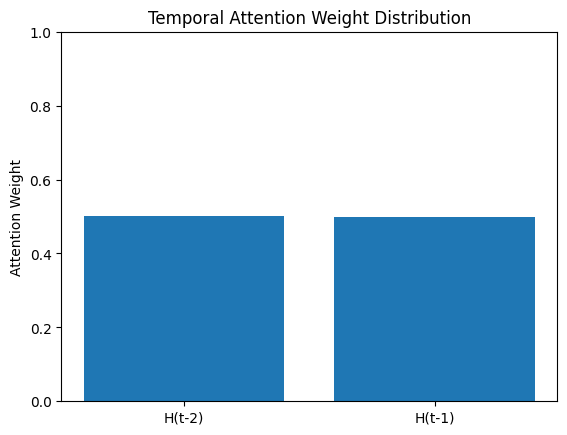

In [20]:
import matplotlib.pyplot as plt
import numpy as np

avg_weights = np.mean(weights, axis=0)

plt.bar(["H(t-2)", "H(t-1)"], avg_weights)
plt.ylabel("Attention Weight")
plt.title("Temporal Attention Weight Distribution")
plt.ylim(0, 1)
plt.show()

**THE ATTENTION-BASED IMPROVED MODEL (Multi-head)**

**Step 1: Attention Module**

In [21]:
class MultiHeadTemporalAttention(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        assert channels % num_heads == 0

        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.ModuleList([
            nn.Linear(self.head_dim, 1) for _ in range(num_heads)
        ])

    def forward(self, x, return_weights=False):
        B, T, C, H, W = x.shape

        x = x.view(B, T, self.num_heads, self.head_dim, H, W)

        fused_heads = []
        weights_all = []

        for h in range(self.num_heads):
            scores = []
            for t in range(T):
                pooled = self.pool(x[:, t, h]).view(B, -1)
                score = self.fc[h](pooled)
                scores.append(score)

            scores = torch.stack(scores, dim=1)  
            weights = torch.softmax(scores, dim=1)

            fused = (x[:, :, h] * weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

            fused_heads.append(fused)
            weights_all.append(weights)

        fused_output = torch.cat(fused_heads, dim=1)

        if return_weights:
            return fused_output, weights_all

        return fused_output

**Step 2: Improved CNN + Attention Model**

In [22]:
class MultiHeadAttentionCNN(nn.Module):
    def __init__(self, num_heads=4):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )

        self.attention = MultiHeadTemporalAttention(
            channels=64,
            num_heads=num_heads
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x, return_weights=False):
        feats = []
        for t in range(x.shape[1]):
            feats.append(self.encoder(x[:, t:t+1]))

        feats = torch.stack(feats, dim=1) 

        if return_weights:
            fused, weights = self.attention(feats, return_weights=True)
            out = self.decoder(fused)
            return out, weights

        fused = self.attention(feats)
        return self.decoder(fused)

**Train the Improved Model (Same Loop as used for the baseline model)**

In [23]:
import torch.optim as optim
attn_model = MultiHeadAttentionCNN().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(attn_model.parameters(), lr=1e-3)

for epoch in range(10):
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        optimizer.zero_grad()
        pred = attn_model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

    print(f"[Attention] Epoch {epoch}: Loss = {loss.item():.4f}")

[Attention] Epoch 0: Loss = 0.0025
[Attention] Epoch 1: Loss = 0.0015
[Attention] Epoch 2: Loss = 0.0014
[Attention] Epoch 3: Loss = 0.0014
[Attention] Epoch 4: Loss = 0.0014
[Attention] Epoch 5: Loss = 0.0014
[Attention] Epoch 6: Loss = 0.0014
[Attention] Epoch 7: Loss = 0.0014
[Attention] Epoch 8: Loss = 0.0014
[Attention] Epoch 9: Loss = 0.0014


**Evaluate Improved Model (Same Metrics used for the Baseline model)**

In [24]:
attn_model.eval()

mse_scores, ssim_scores, pcc_scores = [], [], []

with torch.no_grad():
    for x, y in loader:
        x = x.cuda()
        y = y.cuda().unsqueeze(1)

        pred = attn_model(x)

        mse_scores.append(criterion(pred, y).item())
        ssim_scores.append(compute_ssim(pred[0], y[0]))
        pcc_scores.append(compute_pcc(pred[0], y[0]))

print("Attention Model (Multi-head) Results:")
print("MSE:", np.mean(mse_scores))
print("SSIM:", np.mean(ssim_scores))
print("PCC:", np.mean(pcc_scores))

Attention Model (Multi-head) Results:
MSE: 0.0013970153993882594
SSIM: 0.7862821259611853
PCC: 0.9914981


In [25]:
torch.save(attn_model.state_dict(), "attention.pth")

In [26]:
import json

attention_results = {
    "MSE": float(np.mean(mse_scores)),
    "SSIM": float(np.mean(ssim_scores)),
    "PCC": float(np.mean(pcc_scores))
}

with open("attention_metrics.(Multi-head).json", "w") as f:
    json.dump(attention_results, f, indent=4)

**Extract Attention Weights**

In [27]:
attn_model.eval()

with torch.no_grad():
    x, y = next(iter(loader))
    x = x.cuda()

    pred, weights = attn_model(x, return_weights=True)

weights_np = [
    w.squeeze(-1).cpu().numpy() for w in weights
]

**Visualize attention weights**

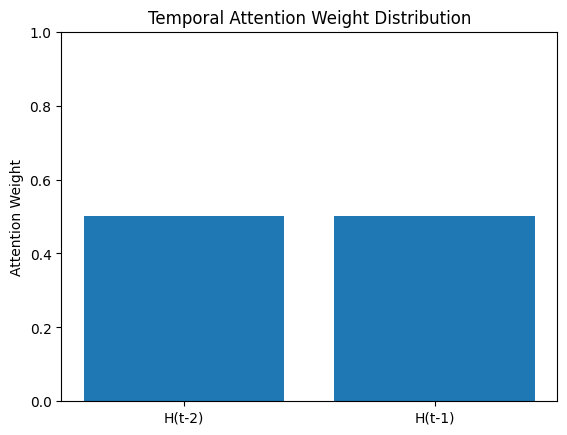

In [28]:
import matplotlib.pyplot as plt
import numpy as np

avg_weights = np.mean(weights_np, axis=0)

avg_weights = np.mean(avg_weights, axis=0) 

plt.bar(["H(t-2)", "H(t-1)"], avg_weights)
plt.ylabel("Attention Weight")
plt.title("Temporal Attention Weight Distribution")
plt.ylim(0, 1)
plt.show()


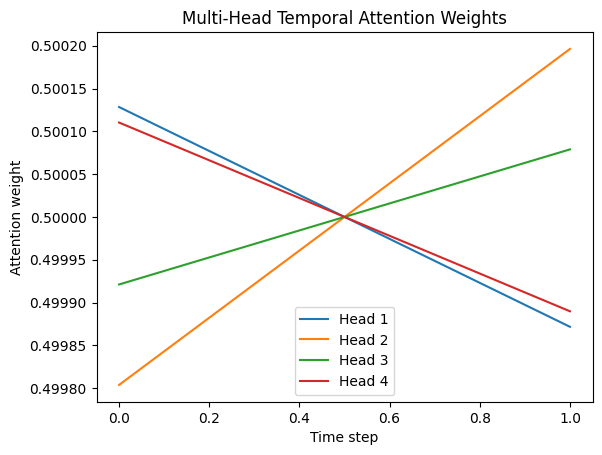

In [29]:
import matplotlib.pyplot as plt

for i, w in enumerate(weights_np):
    plt.plot(w[0], label=f"Head {i+1}")

plt.legend()
plt.xlabel("Time step")
plt.ylabel("Attention weight")
plt.title("Multi-Head Temporal Attention Weights")
plt.show()